# Overview

The goal is to compute a maximum likelihood estimate (MLE) for a particular compound Poisson distribution. First we setup some definitions. Let

$$ N\sim \text{Poisson}(\lambda)  \text{, and } X_j \stackrel{i.i.d.}{\sim} \text{Geometric}(1-p),$$

where the range  of the $X_j$ starts at 0. The parameters \\(\lambda\\) and \\(p\\) are assumed to be unknown. We can think of each \\(X_j\\) as the number of successes before the first failure, where success occurs with probability \\(p\\).

We cannot observe \\(N\\) or the \\(X_j\\). Instead, we only observe \\(n\\) i.i.d. copies of \\(Y\\), where

$$ Y = \sum_{j=1}^N X_j.$$

Such a \\(Y\\) might arise in biology. Perhaps transcription of a gene occurs according to a Poisson process, and once transcription begins, we model the number of mRNA transcripts with a geometric random variable.

Let \\(\{Y_i\}_{i=1}^n\\) denote the i.i.d. copies of \\(Y\\). The goal is to find the maximum likelihood estimates of \\(\lambda\\) and \\(p\\) in a reasonable amount of time without using approximations (other than numerical error). In other words, we want to compute

$$\underset{\lambda,p}{\arg\max} \sum_{i=1}^n \log P(Y=y_i; \lambda, p)$$

subject to the constraints \\(\lambda \ge 0\\) and \\(\epsilon \le p \le 1 - \epsilon\\) for some chosen \\(\epsilon \in (0, 1/2)\\).

The rest of this document is split into multiple sections. First, we will write down the expectation, variance, and probability mass function (p.m.f.) of \\(Y\\) and its derivatives. Second, we will check the p.m.f. by simulating observations of \\(Y\\)  and comparing the corresponding histogram to the p.m.f. values. Third, we will check the derivatives via finite differences. Finally, we will use SciPy's optimization library to compute the MLE.

It seems that this idea can be extended to a generalized linear model, where the parameters \\(\lambda\\) and \\(p\\) depend on known covariates and unknown parameters.

# The expectation and variance

The expectation and variance are easy to derive, so we start with those. The law of total expectation implies that

$$
\begin{align*}
\mathbb{E}[Y] &= \mathbb{E}[\mathbb{E}[Y | N]] \\
&= \mathbb{E}[N p / (1-p)] \\
&= \frac{\lambda p }{1-p} \\
\end{align*}
$$

Similarly, from law of total variance 

$$
\begin{align*}
\text{Var}(Y) &= \mathbb{E}[\text{Var}(Y|N)] + \text{Var}(\mathbb{E}[Y|N]) \\
&= \mathbb{E}[N p / (1-p)^2] + \text{Var}(N p/(1-p)) \\
&= \frac{\lambda p}{(1-p)^2} + \frac{\lambda p^2}{(1-p)^2} \\
&= \frac{\lambda p(1+p)}{(1-p)^2} \\
\end{align*}
$$

Before we proceed, we should state the following fact, because it will be useful later. A finite sum of i.i.d. geometric random variables follows a [negative binomial distribution](https://en.wikipedia.org/wiki/Negative_binomial_distribution#Distribution_of_a_sum_of_geometrically_distributed_random_variables). Therefore, if we condition on \\(N\\), \\(Y\\) is a negative binomial random variable with parameters \\(N\\) and \\(p\\).

Next we check the above moment computations through simulation. We will also show that the negative binomial construction gives the same results. Since there are different parameterizations of the geometric and negative binomial distributions, it is always a good idea to make sure our parameterizations are consistent. If the expectation and variance are correct, then chances are the parameterizations are right.


true expectation: 24.00000000000001
true variance: 216.00000000000017

-------------------------

GEOMETRIC CONSTRUCTION
sample mean : 23.978914
sample variance : 215.94406138060404
standard error: 0.014695035262992874

-------------------------

NEGATIVE BINOMIAL CONSTRUCTION
sample mean: 23.977067
sample variance: 215.720759077511
standard error: 0.014687435415262632

-------------------------

slope of the line: 0.9997964326603934


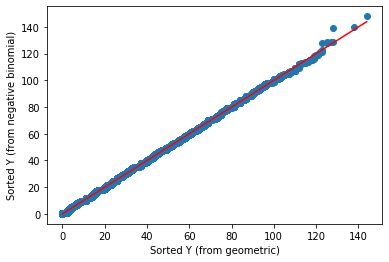

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats

lmbda = 6
p = 0.8
samples = 10**6

N = np.random.poisson(lmbda, size=samples)

###########################
# construct the Y observations with geometric random variables
###########################

#the -1 is so they start from 0 instead of 1
geom = np.random.geometric(1-p, size=np.sum(N)) - 1 
Y_geom = np.array([np.sum(arr) for arr in np.split(geom, np.cumsum(N))[:-1]], dtype=np.int)

###########################
# construct the Y observations with negative binomial random variables
###########################

#np.random.negative_binomial(N, p) does not handle zeros values in N, so we need to work around it
altered_N = np.copy(N)
np.putmask(altered_N, N == 0, 1)
Y_neg_binom = np.random.negative_binomial(altered_N, 1-p)
np.putmask(Y_neg_binom, N == 0, 0) 

###########################
# display the results
###########################

true_expect = lmbda * p / (1-p)
true_var = lmbda * p * (1+p) / (1-p)**2

print(f'true expectation: {true_expect}')
print(f'true variance: {true_var}')
print('\n-------------------------\n')

print('GEOMETRIC CONSTRUCTION')
print(f'sample mean : {np.mean(Y_geom)}')
print(f'sample variance : {np.var(Y_geom)}')
print(f'standard error: {np.std(Y_geom)/np.sqrt(samples)}')
print('\n-------------------------\n')

print('NEGATIVE BINOMIAL CONSTRUCTION')
print(f'sample mean: {np.mean(Y_neg_binom)}')
print(f'sample variance: {np.var(Y_neg_binom)}')
print(f'standard error: {np.std(Y_neg_binom)/np.sqrt(samples)}')
print('\n-------------------------\n')

#make a QQ plot for the two constructions, should roughly see a line with slope 1
#good for detecting subtle errors, especially in the tails
sorted_Y_geom = np.sort(Y_geom)
sorted_Y_neg_binom = np.sort(Y_neg_binom)

slope = np.linalg.lstsq(np.reshape(sorted_Y_geom, (-1, 1)), sorted_Y_neg_binom, rcond=None)[0][0]

plt.scatter(sorted_Y_geom, sorted_Y_neg_binom)
plt.plot(sorted_Y_geom, slope * sorted_Y_geom, color='r')
plt.xlabel('Sorted Y (from geometric)')
plt.ylabel('Sorted Y (from negative binomial)')
print(f'slope of the line: {slope}')

# Probability mass function

